Реализация домашнего задания по предсказания просрочки кредита(HW_26) с помощью PyTotch 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statistics 
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

Начитаем датасет и выведем его основные данные

In [2]:
df = pd.read_csv("cs-training.csv", index_col=0)

print(df.shape)
print(df.info())
df.describe(include = "all").T

(150000, 11)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 150000 entries, 1 to 150000
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    146076 non-null  

,count,mean,std,min,25%,50%,75%,max
SeriousDlqin2yrs,150000.0,0.066840,0.249746,0.0,0.000000,0.000000,0.000000,1.0
RevolvingUtilizationOfUnsecuredLines,150000.0,6.048438,249.755371,0.0,0.029867,0.154181,0.559046,50708.0
age,150000.0,52.295207,14.771866,0.0,41.000000,52.000000,63.000000,109.0
NumberOfTime30-59DaysPastDueNotWorse,150000.0,0.421033,4.192781,0.0,0.000000,0.000000,0.000000,98.0
DebtRatio,150000.0,353.005076,2037.818523,0.0,0.175074,0.366508,0.868254,329664.0
MonthlyIncome,120269.0,6670.221237,14384.674215,0.0,3400.000000,5400.000000,8249.000000,3008750.0
NumberOfOpenCreditLinesAndLoans,150000.0,8.452760,5.145951,0.0,5.000000,8.000000,11.000000,58.0
NumberOfTimes90DaysLate,150000.0,0.265973,4.169304,0.0,0.000000,0.000000,0.000000,98.0
NumberRealEstateLoansOrLines,150000.0,1.018240,1.129771,0.0,0.000000,1.000000,2.000000,54.0
NumberOfTime60-89DaysPastDueNotWorse,150000.0,0.240387,4.155179,0.0,0.000000,0.000000,0.000000,98.0


In [3]:
df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


Заполним пропуски в датасете

In [4]:
cleaned_df = df.copy(deep = True)

# Для MonthlyIncome пропуски заменим наиболее часто встречающимся значением
cleaned_df["MonthlyIncome"].fillna(statistics.mode(cleaned_df["MonthlyIncome"]), inplace=True)

# Для NumberOfDependents пропуски заменим наиболее часто встречающимся значением
cleaned_df["NumberOfDependents"].fillna(statistics.mode(cleaned_df["NumberOfDependents"]), inplace=True)

#в столбце age заменим нулевые элементы наиболее часто встречающимся значением 
cleaned_df.loc[cleaned_df['age'] == 0, 'age'] = statistics.mode(cleaned_df["age"])

#в столбце MonthlyIncome заменим нулевые элементы средним значением 
cleaned_df.loc[cleaned_df['MonthlyIncome'] == 0, 'MonthlyIncome'] = statistics.mean(cleaned_df["MonthlyIncome"])

#в столбце RevolvingUtilizationOfUnsecuredLines заменим нулевые элементы средним значением 
cleaned_df.loc[cleaned_df['RevolvingUtilizationOfUnsecuredLines'] == 0, 'RevolvingUtilizationOfUnsecuredLines'] = statistics.mode(cleaned_df['RevolvingUtilizationOfUnsecuredLines'])

<AxesSubplot: >

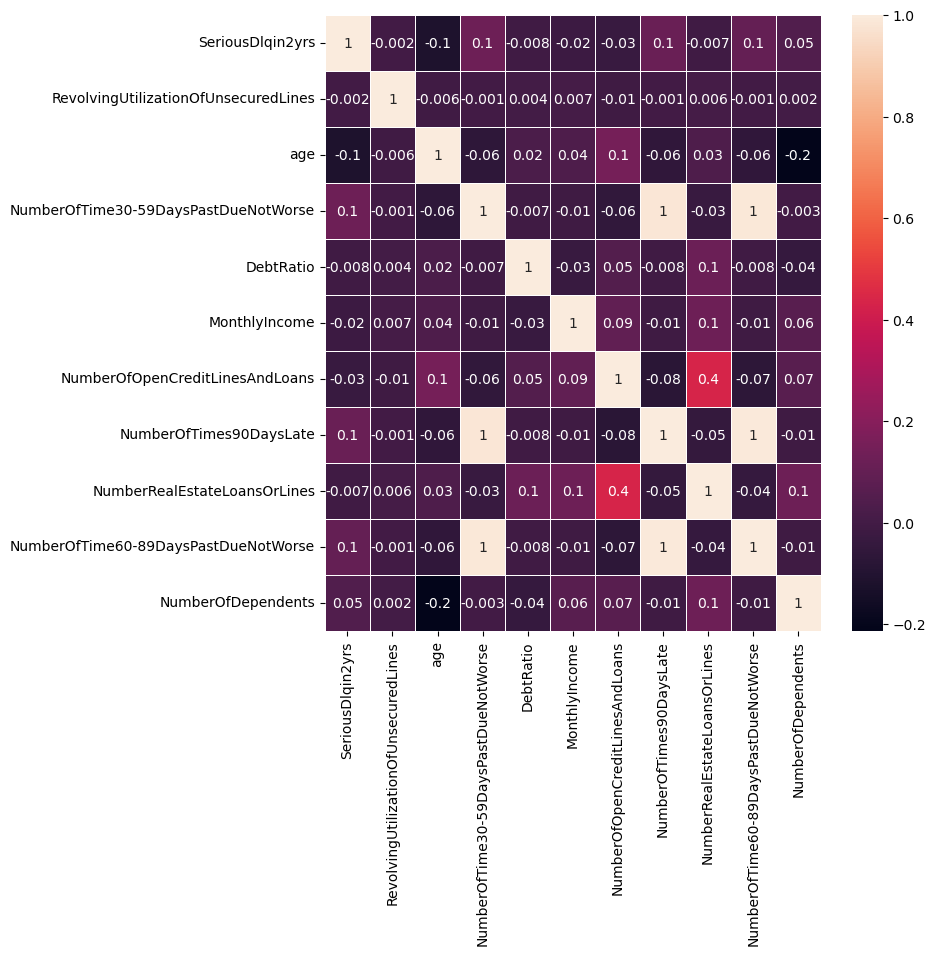

In [5]:
corr_mat = df.corr()

fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(corr_mat, annot=True, linewidths=.5, fmt='.1g')

Отскалируем полученные данные

In [6]:
scaler = StandardScaler()
Y = cleaned_df["SeriousDlqin2yrs"]

X = cleaned_df.drop(["SeriousDlqin2yrs"], axis=1)
X = scaler.fit_transform(X)

## Torch

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [8]:
class Data(Dataset):
  '''Dataset Class to store the samples and their corresponding labels, 
  and DataLoader wraps an iterable around the Dataset to enable easy access to the samples.
  '''

  def __init__(self, X: np.ndarray, y: np.ndarray) -> None:

    # need to convert float64 to float32 else 
    # will get the following error
    # RuntimeError: expected scalar type Double but found Float
    self.X = torch.from_numpy(X.astype(np.float32))
    self.y = torch.from_numpy(y.astype(np.float32))
    self.len = self.X.shape[0]
  
  def __getitem__(self, index: int) -> tuple:
    return self.X[index], self.y[index]

  def __len__(self) -> int:
    return self.len

In [9]:
batch_size = 32

#Generate the training dataset
traindata = Data(X_train, y_train.to_numpy())

# Load the training data into data loader with the 
# respective batch_size and num_workers
trainloader = DataLoader(traindata, batch_size=batch_size, 
                         shuffle=True, num_workers=0)

Определим класс нейронной сети, которой будем обучать модель. Сделаем модель аналогичной той, которую делаи при обучении модели с помощью TensorFlow

In [10]:
class NeuralNetwork(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.input_to_hidden = nn.Linear(10, 128)
        self.hidden_layer_1 = nn.Linear(128, 128)
        self.hidden_layer_2 = nn.Linear(128, 64)
        self.hidden_to_output = nn.Linear(64, 1)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        

        
    def forward(self, inputs):
        out1 = self.relu(self.input_to_hidden(inputs))
        out2 = self.relu(self.hidden_layer_1(out1))
        out3 = self.relu(self.hidden_layer_2(out2))
        out4 = self.sigmoid(self.hidden_to_output(out3))
        return out4
    
model = NeuralNetwork()

# optimizer that will be used to update weights and biases
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
criterion = nn.MSELoss()

# Функция вычисления метрики Accuracy бинарной классификации
def binary_acc(y_pred, y_true):
    y_pred_val = torch.round(torch.sigmoid(y_pred))
    correct_results_sum = torch.eq(y_pred_val, y_true).sum().float()
    acc = correct_results_sum/y_true.shape[0]
    return acc

In [11]:
model

NeuralNetwork(
  (input_to_hidden): Linear(in_features=10, out_features=128, bias=True)
  (hidden_layer_1): Linear(in_features=128, out_features=128, bias=True)
  (hidden_layer_2): Linear(in_features=128, out_features=64, bias=True)
  (hidden_to_output): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

Обучим созданную модель

In [12]:
# start training
epochs = 30
for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0): 
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))# inputs, labels = data
        # forward propagation
        outputs = model(inputs)
        loss = criterion(outputs, targets) 
        # set optimizer to zero grad to remove previous epoch gradients
        optimizer.zero_grad()
        # backward propagation
        loss.backward()

    # optimize
    optimizer.step()
    running_loss += loss.item()

In [13]:
testdata = Data(X_test, y_test.to_numpy())
testloader = DataLoader(testdata, batch_size=batch_size, 
                        shuffle=True, num_workers=0)

In [14]:
model.eval()
# Validate trained model using the test dataset
num_correct = 0
num_examples = 0
with torch.no_grad():
    loss = 0
    for i, (inputs, labels) in enumerate(testloader):
        predictions = model(inputs)# calculate output by running through the network
        labels = torch.from_numpy(labels.detach().cpu().numpy())
        predictions = torch.from_numpy(predictions.detach().cpu().numpy())
#     loss += F.binary_cross_entropy_with_logits(predictions.squeeze().detach(), labels)
        loss += F.binary_cross_entropy(predictions.squeeze().detach(), labels)
#     correct = torch.eq(torch.max(F.softmax(predictions, dim=1), dim=1)[1], labels)
        correct = torch.eq(torch.max(F.sigmoid(predictions), dim=1)[1], labels)
        num_correct += torch.sum(correct).item()
        num_examples += correct.shape[0]
    print(f'BCE loss: {loss / (i + 1):.5f}, accuracy = {num_correct / num_examples}')

D:\Olya_work\anaconda3\envs\New_Environment\lib\site-packages\torch\nn\functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


BCE loss: 6.61869, accuracy = 0.9337777777777778
